In [1]:
import os
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy.stats import poisson
from scipy.interpolate import InterpolatedUnivariateSpline

# colors
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# average NPE for signal (Cherenkov) and background (ambient photons)
sig_mu = 10
bkg_mu = 2

# number of samples for fast-sim
Nsamples = 1000000

In [2]:
# creating a numpy array for x-axis
# using step size as 1
x = np.linspace(0, 20, 21)
xsp = np.linspace(0, 20, 101)
# add several more bins at the end for histogram (a technical choice to get rid of extrapolation unstability)
xbins = np.linspace(0, 20 + 5, 21 + 5)

# get the distributions (and smooth them with the spline fit)
# poisson distribution for background
y_bkg = poisson.pmf(x, mu=bkg_mu)
ysp_bkg = InterpolatedUnivariateSpline(x, y_bkg)(xsp)

# poisson distribution for signal (almost Gaussian)
y_sig = poisson.pmf(x, mu=sig_mu)
ysp_sig = InterpolatedUnivariateSpline(x, y_sig)(xsp)

# uncorrelated sum
ysp_sum = ysp_bkg + ysp_sig

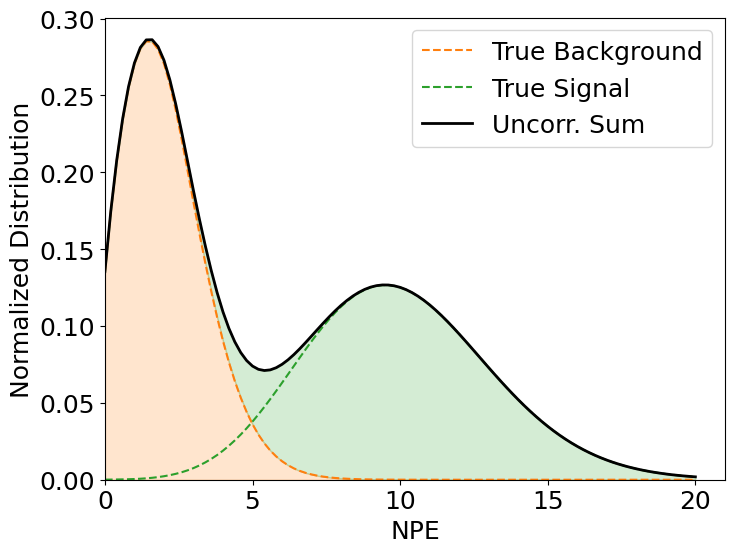

In [3]:
# plot the uncorrelated sum of background and signal
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(xsp, ysp_bkg, label='True Background', color=colors[1], ls='--')
ax.fill_between(xsp, 0, ysp_bkg, color=colors[1], alpha=0.2)
ax.plot(xsp, ysp_sig, label='True Signal', color=colors[2], ls='--')
ax.fill_between(xsp, ysp_bkg, ysp_sum, color=colors[2], alpha=0.2)
ax.plot(xsp, ysp_sum, label='Uncorr. Sum', color='k', ls='-', lw=2)
ax.set_axisbelow(True)
ax.tick_params(labelsize=18)
ax.set_ylabel('Normalized Distribution', fontsize=18)
ax.set_xlabel('NPE', fontsize=18)
ax.legend(fontsize=18)
ax.set_xlim(0)
ax.set_ylim(0)

# showing the graph
plt.show()

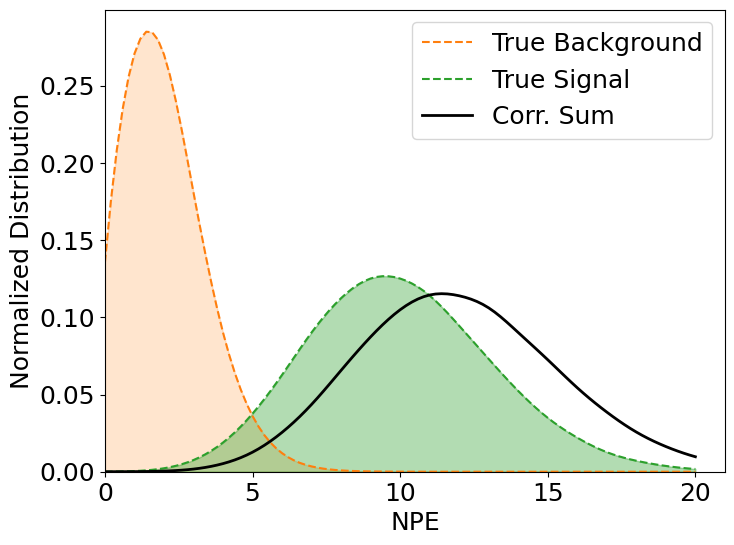

In [6]:
# correlated sum
# assuming every event is signal + background (1:1 ratio, 100% pile-up)
samp_bkg = poisson.rvs(bkg_mu, size=Nsamples)
samp_sig = poisson.rvs(sig_mu, size=Nsamples)
# correlated sum, note the difference (with the sum above) is that this sum happens at event level (piled up)
samp_sum = samp_bkg + samp_sig

# get the distributions (and smooth them with the spline fit)
hvals_sum, _ = np.histogram(samp_sum, bins=xbins)
hvsp_sum = InterpolatedUnivariateSpline(xbins[:-1], hvals_sum/np.sum(hvals_sum))(xsp)

hvals_sig, _ = np.histogram(samp_sig, bins=xbins)
hvsp_sig = InterpolatedUnivariateSpline(xbins[:-1], hvals_sig/np.sum(hvals_sig))(xsp)

hvals_bkg, _ = np.histogram(samp_bkg, bins=xbins)
hvsp_bkg = InterpolatedUnivariateSpline(xbins[:-1], hvals_bkg/np.sum(hvals_bkg))(xsp)

# plot the uncorrelated sum of background and signal
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(xsp, hvsp_bkg, label='True Background', color=colors[1], ls='--')
ax.fill_between(xsp, 0, hvsp_bkg, color=colors[1], alpha=0.2)
ax.plot(xsp, hvsp_sig, label='True Signal', color=colors[2], ls='--')
ax.fill_between(xsp, 0, hvsp_sig, color=colors[2], alpha=0.2)
ax.plot(xsp, hvsp_sum, label='Corr. Sum', color='k', ls='-', lw=2)
ax.fill_between(xsp, 0, hvsp_sig, color=colors[2], alpha=0.2)
ax.set_axisbelow(True)
ax.tick_params(labelsize=18)
ax.set_ylabel('Normalized Distribution', fontsize=18)
ax.set_xlabel('NPE', fontsize=18)
ax.legend(fontsize=18)
ax.set_xlim(0)
ax.set_ylim(0)

# showing the graph
plt.show()

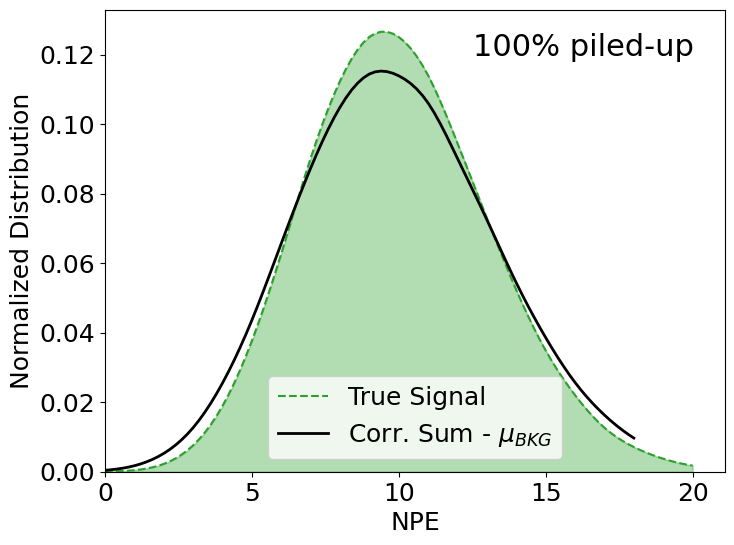

In [7]:
# showing that a fully corr. sum - mean value of background recovers the mean value of signals
# plot the uncorrelated sum of background and signal
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(xsp, hvsp_sig, label='True Signal', color=colors[2], ls='--')
ax.fill_between(xsp, 0, hvsp_sig, color=colors[2], alpha=0.2)
ax.plot(xsp - bkg_mu, hvsp_sum, label=r'Corr. Sum - $\mu_{BKG}$', color='k', ls='-', lw=2)
ax.fill_between(xsp, 0, hvsp_sig, color=colors[2], alpha=0.2)
ax.set_axisbelow(True)
ax.tick_params(labelsize=18)
ax.set_ylabel('Normalized Distribution', fontsize=18)
ax.set_xlabel('NPE', fontsize=18)
ax.legend(loc='lower center', fontsize=18)
ax.set_xlim(0)
ax.set_ylim(0)
ax.text(0.95, 0.95, '100% piled-up', fontsize=22, transform=ax.transAxes, va='top', ha='right')

# showing the graph
plt.show()

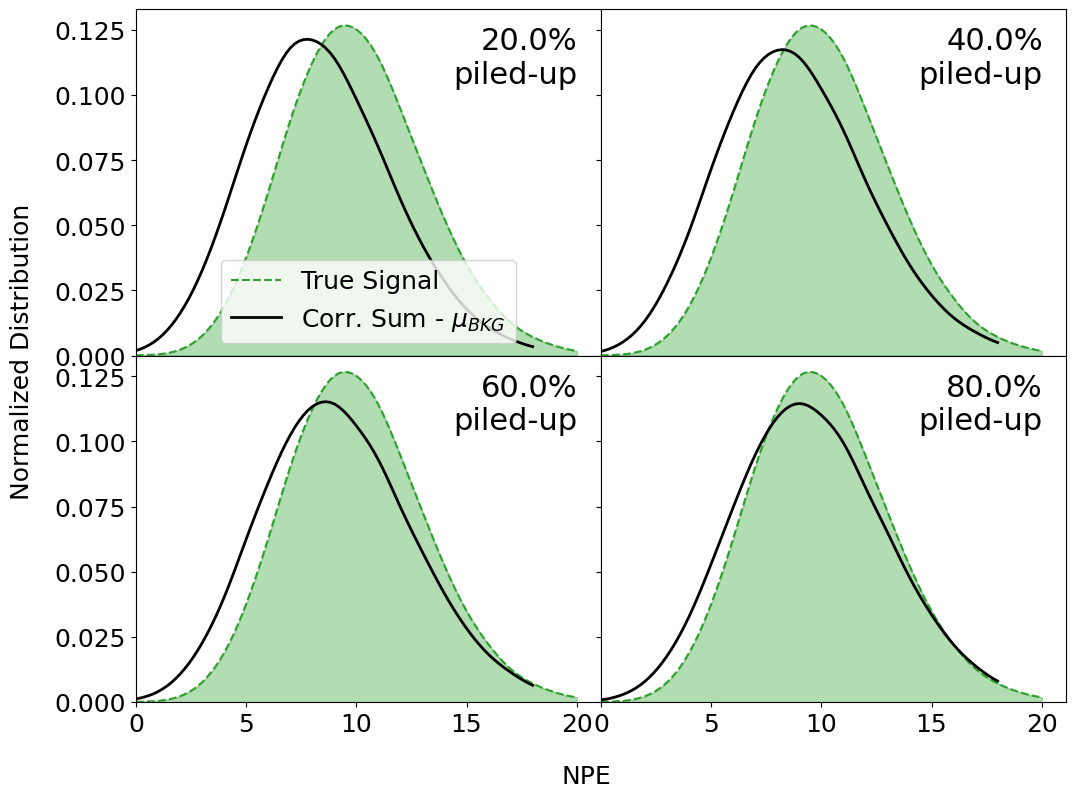

In [8]:
# what if pile-up probability is not 100%?
# For example: 20%, 40%, 60%, 80%
# NOTE that the distributions of signals and backgrounds are not changed
pup_probs = [0.2, 0.4, 0.6, 0.8]
# a uniform [0., 1.] distribution for the pile-up probability sampling
pup = np.random.uniform(0., 1., Nsamples)

fig, axs = plt.subplots(2, 2, figsize=(12, 9), sharex='all', sharey='all', gridspec_kw=dict(hspace=0., wspace=0.))

for i, (pup_prob, ax) in enumerate(zip(pup_probs, axs.flat)):
    # part of the signal is piled-up with background
    samp_sum = samp_sig + (pup <= pup_prob)*samp_bkg
    # get the distributions (and smooth them with the spline fit)
    hvals_sum, _ = np.histogram(samp_sum, bins=xbins)
    hvsp_sum = InterpolatedUnivariateSpline(xbins[:-1], hvals_sum/np.sum(hvals_sum))(xsp)
    
    hvals_sig, _ = np.histogram(samp_sig, bins=xbins)
    hvsp_sig = InterpolatedUnivariateSpline(xbins[:-1], hvals_sig/np.sum(hvals_sig))(xsp)
    
    hvals_bkg, _ = np.histogram(samp_bkg, bins=xbins)
    hvsp_bkg = InterpolatedUnivariateSpline(xbins[:-1], hvals_bkg/np.sum(hvals_bkg))(xsp)
    
    # plot the subtracted result
    ax.plot(xsp, hvsp_sig, label='True Signal', color=colors[2], ls='--')
    ax.fill_between(xsp, 0, hvsp_sig, color=colors[2], alpha=0.2)
    ax.plot(xsp - bkg_mu, hvsp_sum, label=r'Corr. Sum - $\mu_{BKG}$', color='k', ls='-', lw=2)
    ax.fill_between(xsp, 0, hvsp_sig, color=colors[2], alpha=0.2)
    ax.set_axisbelow(True)
    ax.tick_params(labelsize=18)
    ax.set_xlim(0)
    ax.set_ylim(0)
    ax.text(0.95, 0.95, '{}%\npiled-up'.format(pup_prob*100.), fontsize=22, transform=ax.transAxes, va='top', ha='right')
    if i == 0:
        ax.legend(loc='lower center', fontsize=18)

fig.text(0.02, 0.5, 'Normalized Distribution', fontsize=18, va='center', rotation=90)
fig.text(0.5, 0.02, 'NPE', fontsize=18, ha='center')
# showing the graph
plt.show()